In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa
import librosa.display
from random import sample

## Rótulos

Há 50 categorias diferentes de áudio no dataset. Cada categoria foi gravada 5 vezes, representadas pela coluna *take*.

In [3]:
dataset_rotulos = pd.read_csv('data/esc50.csv')
dataset_rotulos.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Dicionário dos valores:


| Coluna    | Significado |
| -------- | ------- |
| filename  | Nome do arquivo    |
| fold | Fold para cross-validation |
| target | categoria, mas com valor (útil para spase categorical cross entropy)|
| category    | Categoria do áudio |
| esc10 | se o áudio faz parte do esc10 ou não |
| src_file | equivalente ao target e category |
| take | indicador da gravação (A a E) |

In [3]:
print(f"O dataset possui {len(dataset_rotulos)} amostras de {len(dataset_rotulos['category'].unique())} categorias diferentes.")

O dataset possui 2000 amostras de 50 categorias diferentes.


## Visualizações

Uma forma de visualização mais comum para áudio é o espectograma. Abaixo, há uma visualização em escala logarítmica. Acho que a escala logarítmica, além de facilitar a visualização, mostra como percebemos áudio. Ex.: susurro numa biblioteca x num concerto. A percepção de altura também segue esta lógica.

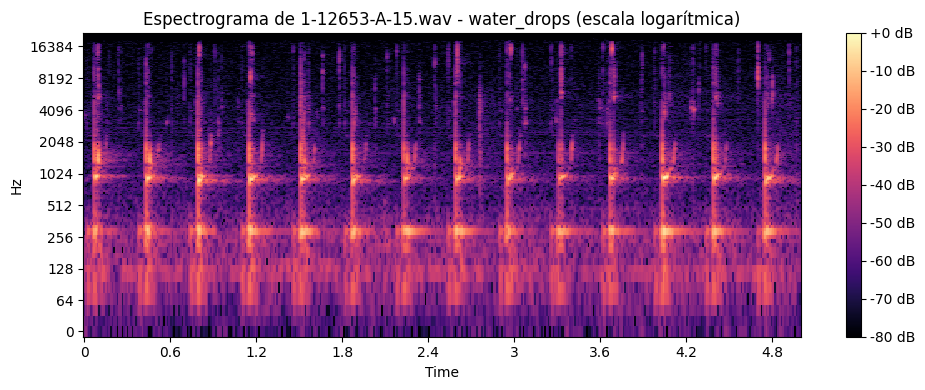

In [4]:
audio_exemplo = dataset_rotulos.iloc[30]["filename"]
rotulo = dataset_rotulos.iloc[30]["category"]
audio_data, sr = librosa.load(f"data/{audio_exemplo}", sr=None)

D = librosa.stft(audio_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Espectrograma de {audio_exemplo} - {rotulo} (escala logarítmica)')
plt.tight_layout()
plt.show()

Ainda pensando sobre logaritmos, a escala de Mel ajusta a frequência da forma como ela é percebida por nós.

$$m(f) = 2595 \log_{10}(1 + \frac{f}{100})$$

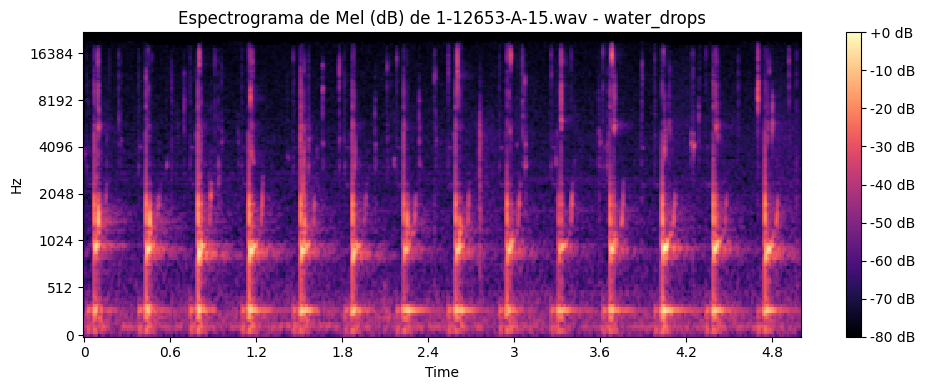

In [5]:
S_mel = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel') # já vem no matplotlib, que bom
plt.colorbar(format='%+2.0f dB')
plt.title(f'Espectrograma de Mel (dB) de {audio_exemplo} - {rotulo}')
plt.tight_layout()
plt.show()

A terceira forma de visualização é uma série temporal, na qual o eixo vertical representa a intensidade. Nem vou testar isso numa rede recorrente ou LSTM porque cada segundo de áudio possui 44100 registros de intensidade. Ou seja, um áudio de 5 segundos possui 220500 pares de (tempo, intensidade). Também fica feio no gráfico.

In [61]:
sr * 5

220500

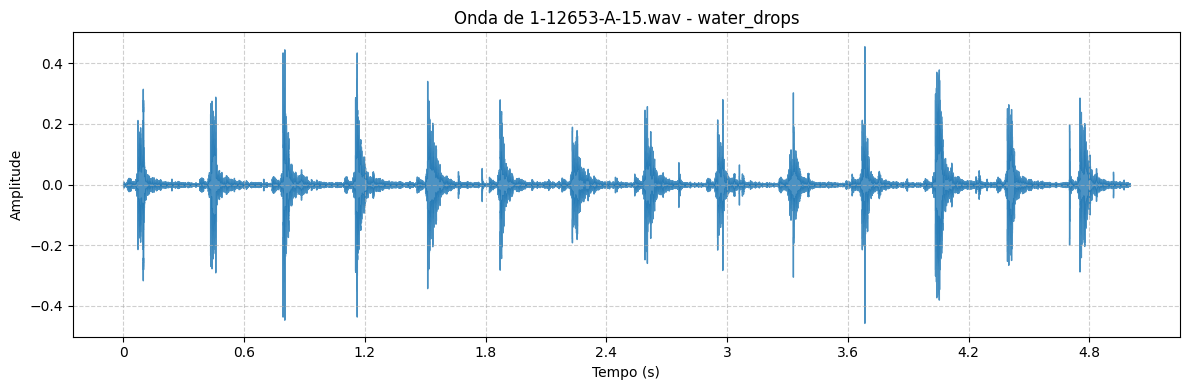

In [6]:
plt.figure(figsize=(12, 4))

librosa.display.waveshow(audio_data, sr=sr, alpha=0.8)

plt.title(f'Onda de {audio_exemplo} - {rotulo}')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Ajusta o layout para não cortar os títulos
plt.show()

## MFCCs

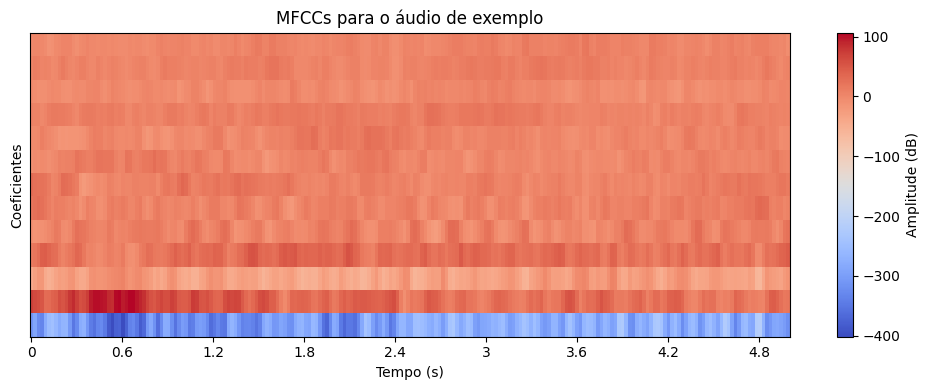

In [37]:
audio_path = f'data/{dataset_rotulos.iloc[2,0]}'
y, sr = librosa.load(audio_path, sr=22050)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='Amplitude (dB)')
plt.title('MFCCs para o áudio de exemplo')
plt.ylabel('Coeficientes')
plt.xlabel('Tempo (s)')
plt.tight_layout()
plt.show()

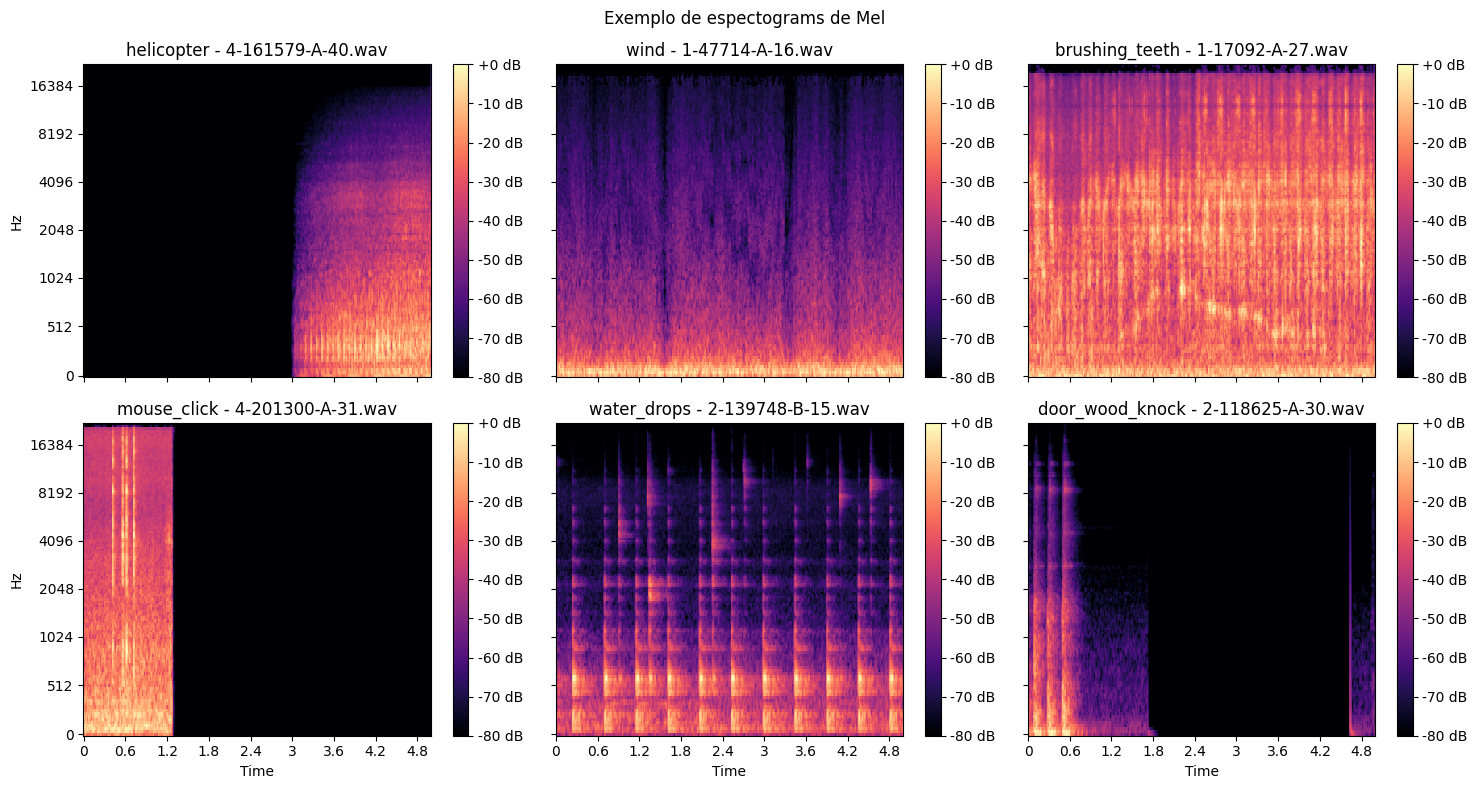

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

from random import sample, seed
seed(42)
sample_indices = sample(range(len(dataset_rotulos)), 6)
dataset_rotulos = dataset_rotulos.iloc[sample_indices]
plt.suptitle("Exemplo de espectograms de Mel")

for i in range(6):
    audio_exemplo = dataset_rotulos.iloc[i]["filename"]
    rotulo = dataset_rotulos.iloc[i]["category"]
    audio_data, sr = librosa.load(f"data/{audio_exemplo}", sr=None)
    
    S_mel = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
    S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
    
    ax = axs[i // 3, i % 3]
    img = librosa.display.specshow(S_mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f'{rotulo} - {audio_exemplo}')
    ax.label_outer()
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout()
plt.show()

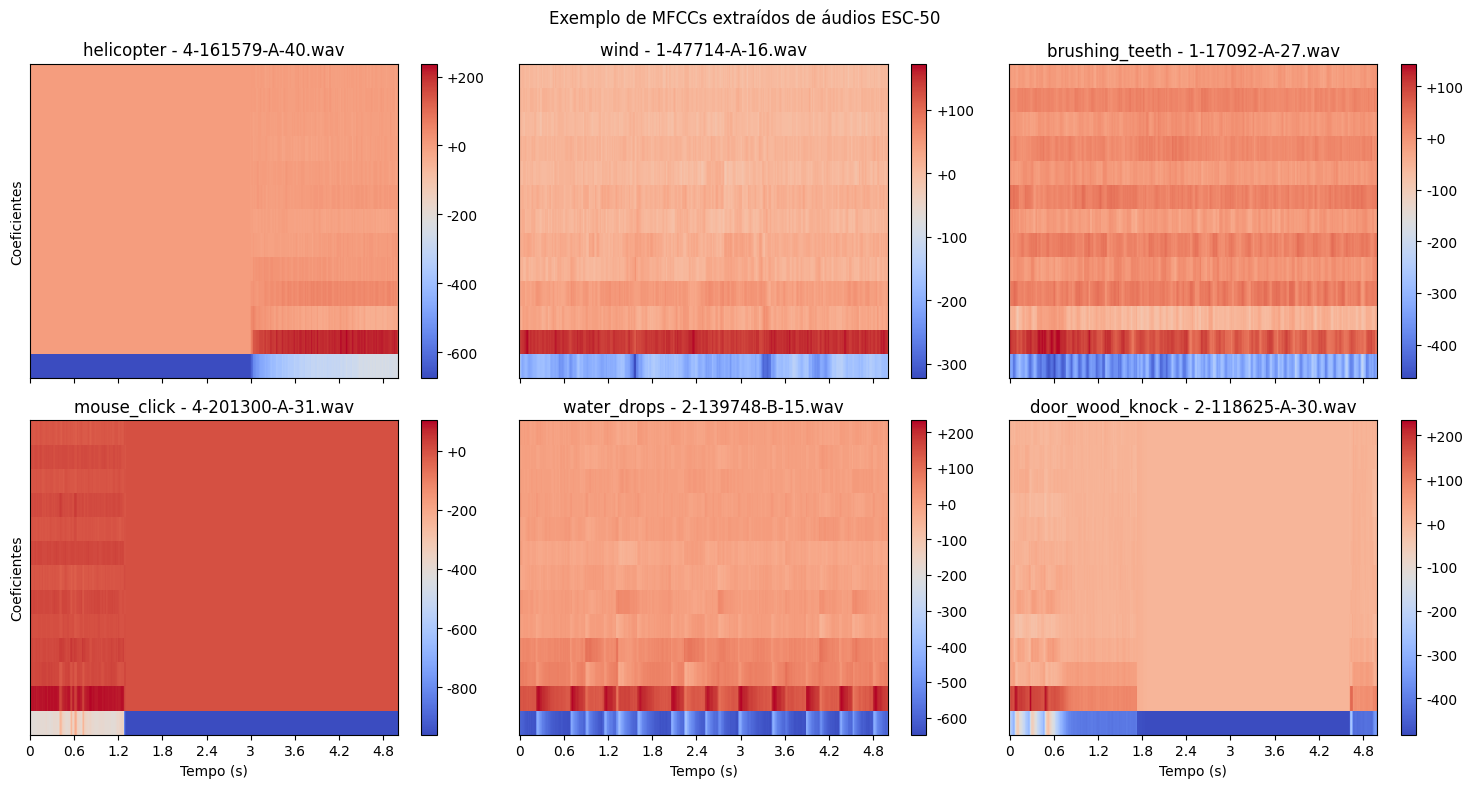

In [39]:
dataset_exemplos = dataset_rotulos

# Criar figura e eixos
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
plt.suptitle("Exemplo de MFCCs extraídos de áudios ESC-50")

# Plotar MFCCs para cada exemplo
for i in range(6):
    audio_exemplo = dataset_exemplos.iloc[i]["filename"]
    rotulo = dataset_exemplos.iloc[i]["category"]
    caminho_audio = f"data/{audio_exemplo}"

    # Carregar áudio
    audio_data, sr = librosa.load(caminho_audio, sr=None)

    # Calcular MFCCs
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    
    # Plotar
    ax = axs[i // 3, i % 3]
    img = librosa.display.specshow(mfcc, x_axis='time', ax=ax, sr=sr)
    ax.set_title(f'{rotulo} - {audio_exemplo}')
    ax.set_ylabel("Coeficientes")
    ax.set_xlabel("Tempo (s)")
    ax.label_outer()
    fig.colorbar(img, ax=ax, format='%+2.0f')

plt.tight_layout()
plt.show()

## Mel espectograma médio

In [4]:
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
FIXED_LENGTH = 216

from random import seed

seed(42)
categorias = sorted(dataset_rotulos["category"].unique())
categorias_selecionadas = sample(categorias, 20)

In [ ]:
def gerar_mel_medio(categoria):
    arquivos = dataset_rotulos[dataset_rotulos["category"] == categoria]["filename"]
    specs = []

    for filename in arquivos:
        y, sr = librosa.load(f"data/audio/{filename}", sr=SAMPLE_RATE)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        if mel_db.shape[1] < FIXED_LENGTH:
            pad_width = FIXED_LENGTH - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :FIXED_LENGTH]

        specs.append(mel_db)

    specs = np.array(specs) # média
    return np.mean(specs, axis=0)

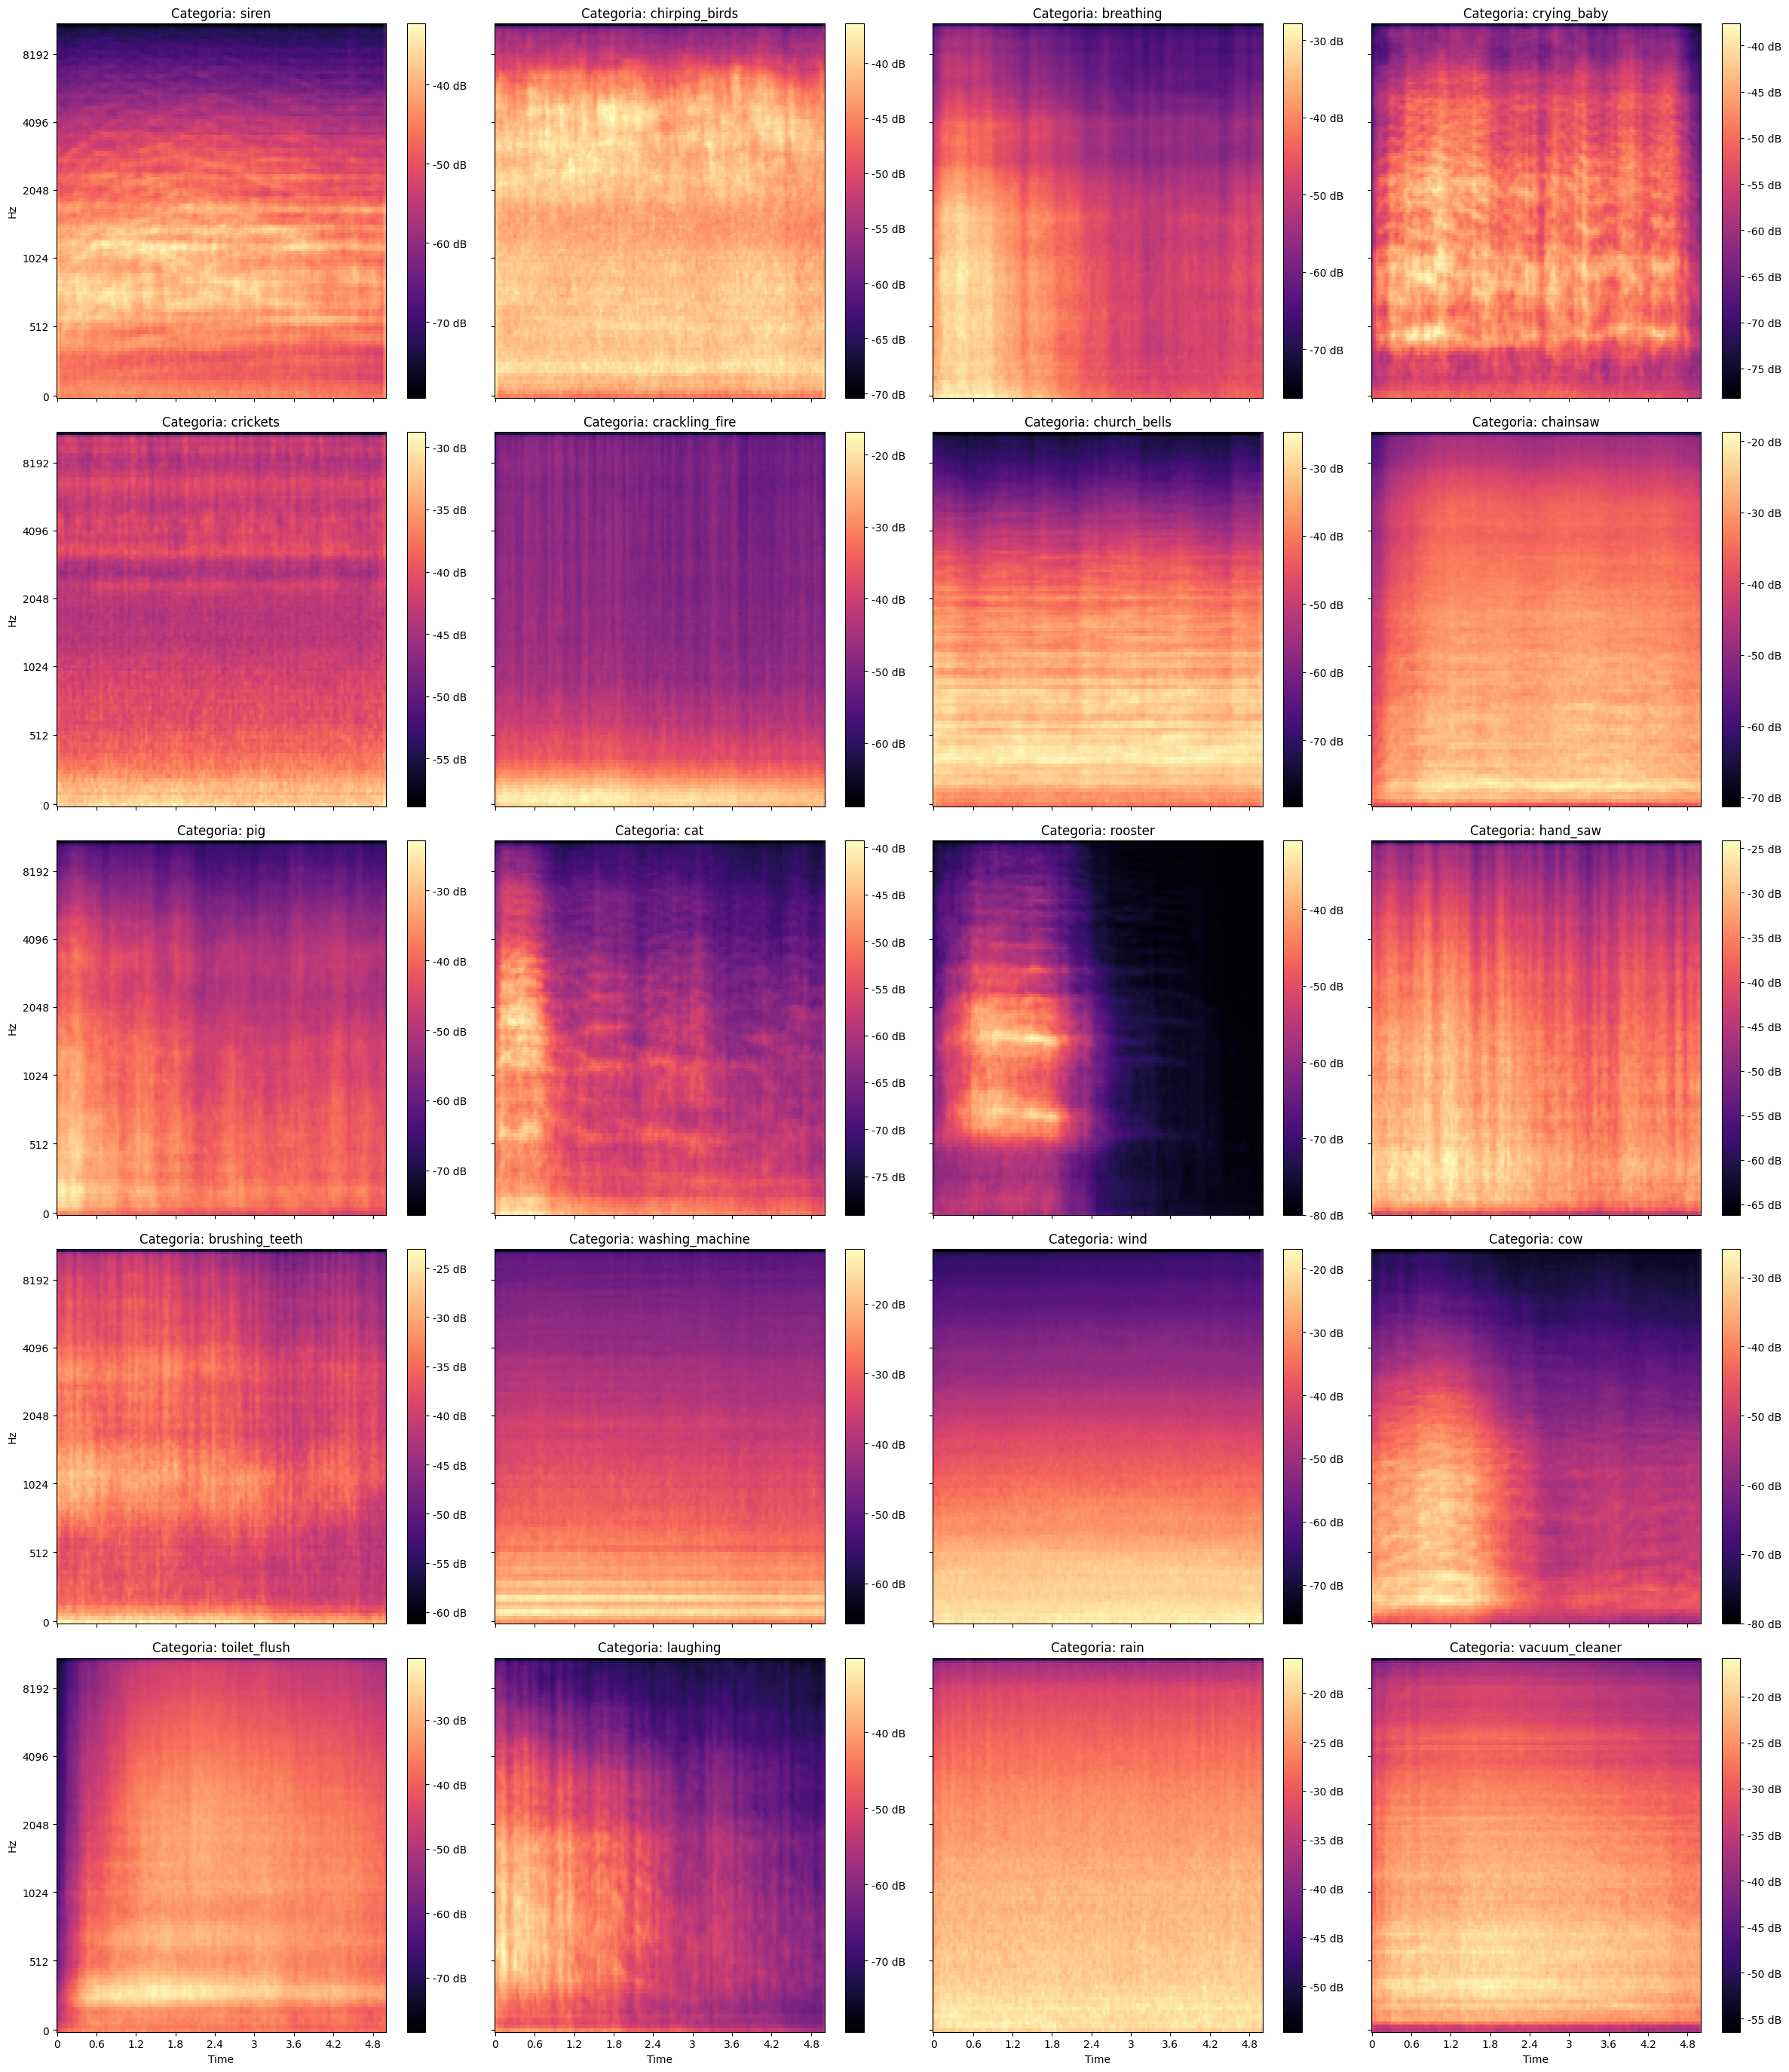

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(24, 30))

for i, categoria in enumerate(categorias_selecionadas):
    mel_medio = gerar_mel_medio(categoria)
    ax = axs[i // 4, i % 4]
    img = librosa.display.specshow(mel_medio, sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                                   x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f'Categoria: {categoria}')
    ax.label_outer()
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig("mel_medio_por_categoria.png", dpi=300, bbox_inches='tight')
plt.show()